## ПЗ 7

Задание

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pymorphy2 import MorphAnalyzer
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import os
import matplotlib.pyplot as plt

import tensorflow as tf
tf.__version__

import tensorflow.keras.layers as L
from tensorflow.keras import Model, Sequential

In [ ]:
data =pd.read_excel('отзывы за лето.xls')
data

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


In [ ]:
mystopwords = stopwords.words("russian")
morpher = MorphAnalyzer()


def words_only(text):
    text =str(text)
    return text.lower()   

def remove_punkt(text, ptrn):
    return re.sub(ptrn, ' ', text)

def to_token(text):
    return nltk.tokenize.word_tokenize(text)

def remove_stopwords(text, stop_words = mystopwords):
    return [w for w in text if w not in stop_words]

def join_to_str(text_list):
    return ' '.join(word for word in text_list)

def morphe_text(txt):
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in mystopwords]
    return " ".join(txt)




data['Content_1'] = data['Content'].apply(words_only)
data['Content_1'] = data['Content_1'].apply(remove_punkt, ptrn=r'[^a-zA-Zа-яА-Я0-9]')
data['Content_1'] = data['Content_1'].apply(to_token)
data['Content_1'] = data['Content_1'].apply(remove_stopwords)
data['Content_1'] = data['Content_1'].apply(join_to_str)
data['Content_1'] = data['Content_1'].apply(morphe_text)

data

,Rating,Content,Date,Content_1
0,5,It just works!,2017-08-14,it just works
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложение минус хотеть слишко...
2,5,Отлично все,2017-08-14,отлично
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать 1 работа антивирус далёкий нику...
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро
...,...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01,шляпа роот право бесполезный прога разраб охре...
20655,5,Ок,2017-06-01,около
20656,4,Доволен,2017-06-01,довольный
20657,1,"Песопаснасть, рут ни нужын",2017-06-01,песопаснастя рута нужын


In [ ]:
words_counter = Counter((word for text in data.Content_1 for word in text.split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 3:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

{k: v for k, v in sorted(words_counter.items(), key=lambda item: item[1], reverse=True)}

Words count 2900


{'приложение': 6762,
 'очень': 3866,
 'удобно': 3602,
 'работать': 2034,
 'удобный': 1786,
 'вс': 1690,
 'спасибо': 1430,
 'отлично': 1380,
 'нравиться': 1148,
 'телефон': 1051,
 'хороший': 1042,
 'отличный': 1021,
 'это': 917,
 'супер': 890,
 'обновление': 818,
 'быстро': 802,
 'просто': 733,
 'мочь': 733,
 'пользоваться': 715,
 'пароль': 715,
 'банк': 712,
 'антивирус': 704,
 'сбербанк': 636,
 'раз': 595,
 'устраивать': 592,
 'вход': 590,
 'пока': 583,
 'карта': 575,
 'прошивка': 549,
 'проблема': 501,
 'рута': 487,
 'писать': 474,
 'свой': 430,
 'программа': 427,
 'перевод': 425,
 'разработчик': 420,
 'сделать': 420,
 'время': 402,
 'деньга': 402,
 'ошибка': 401,
 'приходиться': 388,
 'код': 384,
 'вводить': 377,
 'норма': 374,
 'нормально': 368,
 'так': 366,
 'стать': 362,
 'почему': 359,
 'постоянно': 351,
 'счёт': 345,
 'долго': 344,
 'платёж': 342,
 'около': 341,
 'довольный': 340,
 'смс': 339,
 'право': 337,
 'исправить': 334,
 'ваш': 324,
 'который': 320,
 'понятно': 318,
 'фу

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.Content_1, data.Rating, test_size=0.33, random_state=42)

In [ ]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

max_len = 150
X_train = convert(X_train, word2idx, max_len)
X_test = convert(X_test, word2idx, max_len)

In [ ]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(y_train) 
test_enc_labels = le.transform(y_test)
le.classes_

array([1, 2, 3, 4, 5])

In [ ]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
dim = int(len(word2idx)**(1/2))
num_classes = len(data.Rating.unique())

In [ ]:
X_train.shape[1]

150

## CNN

In [ ]:
inputs = L.Input(shape=(X_train.shape[1],))
embedded_sequences = L.Embedding(input_dim=len(word2idx), output_dim=dim)(inputs)
l_cov1= L.Conv1D(128, 3, activation='relu')(embedded_sequences)
l_cov2 = L.Conv1D(256, 2, activation='relu')(l_cov1)
l_pool1 = L.MaxPooling1D(2)(l_cov2)
l_flat = L.Flatten()(l_pool1)
l_dense = L.Dense(128, activation='relu')(l_flat)
l_d = L.Dropout(0.9)(l_dense)
preds = L.Dense(num_classes, activation='softmax')(l_d)

model = Model(inputs=inputs, outputs=preds)
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 53)           153700    
_________________________________________________________________
conv1d (Conv1D)              (None, 148, 128)          20480     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 147, 256)          65792     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 73, 256)           0         
_________________________________________________________________
flatten (Flatten)            (None, 18688)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               239219

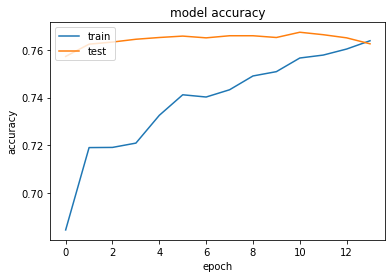

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [ ]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 1s 5ms/step - loss: 0.7540 - accuracy: 0.7674


[0.7539768218994141, 0.7673804759979248]

## CNN с предобученным Embedding

Использовал корпус "НКРЯ и Википедия за декабрь 2018"

In [ ]:
embeddings_index = dict()
f = open('model.txt')
for line in f:
    values = line.split()
    word = re.split(r'_', values[0])[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 207789 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word2idx), 300))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
inputs = L.Input(shape=(X_train.shape[1],))
embedded_sequences = L.Embedding(input_dim=len(word2idx), weights=[embedding_matrix], output_dim=300, trainable=False)(inputs)
l_cov1= L.Conv1D(128, 3, activation='relu')(embedded_sequences)
l_cov2 = L.Conv1D(256, 2, activation='relu')(l_cov1)
l_pool1 = L.MaxPooling1D(2)(l_cov2)
l_flat = L.Flatten()(l_pool1)
l_dense = L.Dense(128, activation='relu')(l_flat)
l_d = L.Dropout(0.9)(l_dense)
preds = L.Dense(num_classes, activation='softmax')(l_d)

model = Model(inputs=inputs, outputs=preds)
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          870000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 148, 128)          115328    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 147, 256)          65792     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 73, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18688)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2392

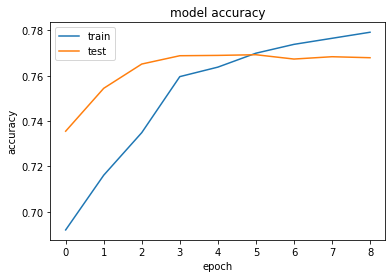

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [ ]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 1s 6ms/step - loss: 0.6974 - accuracy: 0.7693


[0.6974319815635681, 0.7692871689796448]

## Вывод:

Или я что-то сделал не так, но разницы я не увидел 